## Target Data for SCGSR

* **Author** Katie Murenbeeld
* **Date** 19 July 2021


The purpose of this notebook is to neatly organize the target data for single point SCGSR runs. 
This data includes: 

* **Leaf Area Index (lai)** from MODIS
* **Gross Primary Productivity (gpp)** from MODIS 
* **Net Primary Productivity (npp)** from MODIS
* *MODIS data includes annual mean values from 2002-2019 for a single point (sp) and the Bear Run unit of Boise Basin Experimental Forest (br)
* **Aboveground Biomass (agb)** from Wilson et al., 2013 which is derived from USDA Forest Inventory Analysis (FIA) 
* **Diameter a Breast Height (DBH)** and **Height (H)** data from BBEF census data, Forest Vegetation Simulator (FVS) percent tree coverage for 2016 and 2046 from BBEF, and FIA from Idaho; 
* and **DBH**, **H**, **basal area (BA)**, and **carbon volumes** from Forest Inventory Analysis (FIA).

I will also create cost functions ($r^2$ and RMSE) and create a template for using Taylor Diagrams. 

Allometric data and exploration can be found in the SCGSR_Target_Data_Allometry notebook.


## 1. Import libraries and data

In [401]:
# Import libraries

import xarray as xr # for working with netcdf and tiff
import rasterio as rs # for workign with tiff files
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
from scipy.optimize import curve_fit
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [402]:
# Set input and output directories

data_in = '/Users/kathrynmurenbeeld/CODING/SCGSR/DATA/'
agb_in = '/Users/kathrynmurenbeeld/QGIS/DATA/RDS-2013-0004/Data/'
baad_in = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/baad_downloads/baad_data/'

data_out = '/Users/kathrynmurenbeeld/Desktop/SCGSR/WORK/TARGET_DATA_OUT/'


### Forest Inventory Analysis (FIA) from USDA Forest Service

The USDS Forest Inventory Analysis (FIA) data is only for Idaho. Last accessed 17 May 2021 from https://apps.fs.usda.gov/fia/datamart/CSV/datamart_csv.html

In [403]:
# Load Idaho FIA data

fia_tree = pd.read_csv(data_in + 'ID_TREE.csv')
fia_cond = pd.read_csv(data_in + 'ID_COND.csv')

fia_cond.head(2)
fia_tree.head(2)

/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (27,55,58,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CN,PLT_CN,PREV_TRE_CN,INVYR,STATECD,UNITCD,COUNTYCD,PLOT,SUBP,TREE,...,CORE_LENGTH_PNWRS,CULTURALLY_KILLED_PNWRS,DIA_EST_PNWRS,GST_PNWRS,INC10YR_PNWRS,INC5YRHT_PNWRS,INC5YR_PNWRS,RING_COUNT_INNER_2INCHES_PNWRS,RING_COUNT_PNWRS,SNAG_DIS_CD_PNWRS
0,3156115010690,3156095010690,NaN,1991,16,1,9,1,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3156116010690,3156095010690,NaN,1991,16,1,9,1,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Forest Vegetation Simulator (FVS) from USDA Forest Service for Boise Basin Experimental Forest (BBEF)

This Forest Vegetation Simulator (FVS) data was provided to me by USDS Forest Service Employees. This data is for the Boise Basin Experimental Forest (BBEF). The data with suffix of 2046 is assumed to be simulated data. The data with suffix 2016 could either be input data or simulated data. Either way the ratios of ponderosa pine to Douglas-fir will serve as a useful comparison for coexistence of these two species (and corresponding PFTs).

In [404]:
# Load BBEF FVS data

fvs = pd.read_csv(data_in + 'FVSOut_Stand_Data_2016_2046.csv')

fvs.head(1)

,OBJECTID,SETTING_ID,STAND_CN,POLY_ID,ACRES,PV_CODE,Hab_Type,PVG,Fire_Regime,Notes,...,SG_M_30_2046,SG_L_30_2046,SG_PPM30_2046,SG_PPL30_2046,SG_DFM30_2046,CWD_3_2046,CWD_12_2046,PCT_CW12_2046,Shape_Length,Shape_Area
0,1,402030033110864,4.466501e+10,864,210.923701,41344,PSME/SPBE/PIPO,2.0,Non-lethal,,...,10.35,2.51,7.44,2.18,5.09,13.04,4.01,30.74,5515.922705,853577.934


### Boise Basin Experimental Forest (BBEF) Census Data

This data was provided by USDA Forest Service employees. This data contains height and diameter at breast height for species within BBEF. The study name refers to historic, ongoing, or planned experimental treatments.

In [405]:
# Load BBEF dbh and height data

bbef = pd.read_csv(data_in + 'BBEF-all-trees-height_DBH_calcs.csv', 
                   usecols = ["BBEF Study-name", "Year", "Plot ID", "Tree ID", "Species", "Height (feet)", "DBH (inches)", "DBH (cm)", "H (m)", "AGB "])
bbef.head(2)

,BBEF Study-name,Year,Plot ID,Tree ID,Species,DBH (inches),Height (feet),DBH (cm),H (m),AGB
0,Amber Fuels,2013,451,1,Ponderosa pine,31.600000,127.0,80.264000,38.7096,7.961826
1,Amber Fuels,2013,451,2,Ponderosa pine,20.700001,102.0,52.578003,31.0896,5.063293


### MODIS Data

Annual average leaf area index (LAI), gross and net primary production (GPP, NPP) from satellite data. 
Need to figure out how to get raw or finer temporal scale data.

In [406]:
# Load MODIS data

# single point .csv files
lai_sp = pd.read_csv(data_in + "BBEF-LAI-MOD15A2H-006-results.csv")
gpp_sp = pd.read_csv(data_in + "BBEF-GPP-MOD17A2H-006-results.csv")
npp_sp = pd.read_csv(data_in + "BBEF-NPP-MOD17A3HGF-006-results.csv")

# small area (Bear Run Unit of BBEF) .nc files
lai_br = xr.open_dataset(data_in + "MOD15A2H.006_500m_aid0001.nc", decode_times=False)
gpp_br = xr.open_dataset(data_in + "MOD17A2H.006_500m_aid0001.nc", decode_times=False)
npp_br = xr.open_dataset(data_in + "MOD17A3HGF.006_500m_aid0001.nc", decode_times=False)


### Aboveground biomass (AGB) from Wilson et al., 2013

AGB data from .img files created by Wilson et al., 2013. These values are determined from FIA data. 

I have created two clipped .tif files corresponding to each of the two Weather Research Forecasting (WRF) climate forcing data domains. Domain 01 is larger, covering the Snake River Basin, and coarser (4km resolution). Domain 02 is smaller and finer resolution (1km).

In [407]:
# Load the above ground biomass data. Here just the .tiff file for WRF domain 02.

agb_bnf = rs.open(agb_in + "carbon_ag_mg_boisenf.tif")
#agb_d01 = rs.open(agb_in + "carbon_ag_mg_wrf_d01.tif")
#agb_d02 = rs.open(agb_in + "carbon_ag_mg_wrf_d02.tif")
agb_bnf

<open DatasetReader name='/Users/kathrynmurenbeeld/QGIS/DATA/RDS-2013-0004/Data/carbon_ag_mg_boisenf.tif' mode='r'>

## 2. Combine and clean up the datasets as needed
### Unit conversions to match FATES output units

**Within FATES**

* DBH = $cm$
* H = $m$
* ABG = $gC/m^2$
* LAI = $m^2/m^2$
* GPP and NPP = $gC/m^2s$

### First, the FIA data


In [408]:
# From the FIA data
# Only want live trees (STATUSCD=1)
# Only want diameter at breast height (DIAHTCD=1)
# Want to combine tree and condition by PLT_CN 

fia_tree2 = fia_tree.loc[(fia_tree['STATUSCD']==1) & (fia_tree['DIAHTCD']==1)].copy()
fia_tree2.head(2)

,CN,PLT_CN,PREV_TRE_CN,INVYR,STATECD,UNITCD,COUNTYCD,PLOT,SUBP,TREE,...,CORE_LENGTH_PNWRS,CULTURALLY_KILLED_PNWRS,DIA_EST_PNWRS,GST_PNWRS,INC10YR_PNWRS,INC5YRHT_PNWRS,INC5YR_PNWRS,RING_COUNT_INNER_2INCHES_PNWRS,RING_COUNT_PNWRS,SNAG_DIS_CD_PNWRS
0,3156115010690,3156095010690,NaN,1991,16,1,9,1,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3156116010690,3156095010690,NaN,1991,16,1,9,1,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [409]:
# Subset by columns
# 'FGROWCFGS' forget why I thought this variable was important.

fia_tree2 = fia_tree2[['PLT_CN', 'COUNTYCD', 'INVYR', 'CONDID', 'AZIMUTH', 'SPCD', 'SPGRPCD', 
                       'DIA', 'HT', 'CR', 'CCLCD', 'CDENCD', 'BHAGE', 'TPA_UNADJ',  
                       'DRYBIO_BG', 'CARBON_AG', 'CARBON_BG', 'DRYBIO_AG']].copy()

fia_tree2.head(2)

,PLT_CN,COUNTYCD,INVYR,CONDID,AZIMUTH,SPCD,SPGRPCD,DIA,HT,CR,CCLCD,CDENCD,BHAGE,TPA_UNADJ,DRYBIO_BG,CARBON_AG,CARBON_BG,DRYBIO_AG
0,3156095010690,9,1991,1,89.0,202,10,10.6,57.0,65.0,3.0,NaN,28.0,13.054000,110.124965,240.460065,55.062483,NaN
1,3156095010690,9,1991,1,133.0,202,10,6.8,45.0,45.0,3.0,NaN,32.0,31.720993,37.630405,80.531243,18.815203,NaN


In [410]:
# Calculate per acre above ground caron by multiplying the CARBON_AG * TPA_UNADJ

fia_tree2['AGB'] = (fia_tree2['CARBON_AG'] * fia_tree2['TPA_UNADJ'])

# Convert lbC/ha to gC/m^2 to match FATES

fia_tree2['AGB'] = (fia_tree2['AGB'].values * 453.592 * 0.000247105)
fia_tree2['AGB'].mean()

fia_tree2['AGB2'] = (fia_tree2['CARBON_AG'].values * 453.592) # gC/tree?
fia_tree2['AGB2'].mean()

# Maybe this won't be useful...

157431.64480850214

In [411]:
fia_tree2['AGB'].max()

11957.91904269823

In [412]:
# Convert the Height from feet to m
# Covert the DBH from inches to cm

fia_tree2['HT'] = (fia_tree2['HT'] * 0.3048)
fia_tree2['DIA'] = (fia_tree2['DIA'] / 2.54)

In [413]:
fia_tree2['DIA'].max()

37.28346456692913

In [414]:
# Look at the unique species

fia_tree2['SPCD'].unique()

array([202, 242, 264,  19, 119,  17,  73, 122, 263, 108,  93, 375, 746,
       747, 231, 101, 113, 740, 749, 351,  64, 374,  72, 974])

In [415]:
# Replace SPCD with species string

conditions = [
        (fia_tree2['SPCD'] == 202), # Douglas fir
        (fia_tree2['SPCD'] == 242), # Western red cedar
        (fia_tree2['SPCD'] == 19),  # Subalpine fir
        (fia_tree2['SPCD'] == 119), # Western white pine
        (fia_tree2['SPCD'] == 17),  # Grand fir
        (fia_tree2['SPCD'] == 73),  # Western larch
        (fia_tree2['SPCD'] == 122), # Ponderosa pine
        (fia_tree2['SPCD'] == 263), # Western hemlock
        (fia_tree2['SPCD'] == 108), # Lodgepole pine
        (fia_tree2['SPCD'] == 93),  # Engleman spruce
    ]
choices = ['doug-fir', 'w_redcedar', 'subap_fir', 'w_whitepine', 'grand_fir', 'w_larch', 'pondo_pine', 'w_hem', 'lodge_pine', 'engle_spruce']
    
fia_tree2['SPECIES'] = np.select(conditions, choices, default='none')

fia_tree2.head(5)

,PLT_CN,COUNTYCD,INVYR,CONDID,AZIMUTH,SPCD,SPGRPCD,DIA,HT,CR,...,CDENCD,BHAGE,TPA_UNADJ,DRYBIO_BG,CARBON_AG,CARBON_BG,DRYBIO_AG,AGB,AGB2,SPECIES
0,3156095010690,9,1991,1,89.0,202,10,4.173228,17.3736,65.0,...,NaN,28.0,13.054000,110.124965,240.460065,55.062483,NaN,351.830502,109070.761803,doug-fir
1,3156095010690,9,1991,1,133.0,202,10,2.677165,13.7160,45.0,...,NaN,32.0,31.720993,37.630405,80.531243,18.815203,NaN,286.324226,36528.327575,doug-fir
3,3156095010690,9,1991,1,253.0,202,10,8.149606,26.5176,75.0,...,NaN,59.0,3.423000,568.025095,1261.636193,284.012548,NaN,484.047474,572268.084055,doug-fir
4,3156095010690,9,1991,1,285.0,202,10,6.811024,23.7744,75.0,...,NaN,52.0,4.901000,368.684807,816.035383,184.342404,NaN,448.270967,370147.121446,doug-fir
5,3156095010690,9,1991,1,47.0,202,10,0.551181,3.6576,25.0,...,NaN,31.0,60.000000,0.698412,1.129724,0.349206,NaN,7.597497,512.433769,doug-fir


In [416]:
# Subset ID_COND by columns

fia_cond2 = fia_cond[['PLT_CN', 'COUNTYCD', 'CONDID', 'COND_STATUS_CD', 'INVYR', 'DSTRBCD1', 'DSTRBYR1', 
                      'DSTRBCD2', 'DSTRBYR2', 'DSTRBCD3', 'DSTRBYR3', 'TRTCD1', 'TRTYR1', 'BALIVE',
                     'CARBON_DOWN_DEAD', 'CARBON_LITTER', 'CARBON_SOIL_ORG', 'CARBON_STANDING_DEAD', 'CARBON_UNDERSTORY_AG', 'CARBON_UNDERSTORY_BG']].copy()

fia_cond2.head(2)

,PLT_CN,COUNTYCD,CONDID,COND_STATUS_CD,INVYR,DSTRBCD1,DSTRBYR1,DSTRBCD2,DSTRBYR2,DSTRBCD3,DSTRBYR3,TRTCD1,TRTYR1,BALIVE,CARBON_DOWN_DEAD,CARBON_LITTER,CARBON_SOIL_ORG,CARBON_STANDING_DEAD,CARBON_UNDERSTORY_AG,CARBON_UNDERSTORY_BG
0,3156095010690,9,1,1,1991,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.6045,1.739383,14.586436,17.327928,3.456986,0.981080,0.109009
1,3156135010690,9,1,1,1991,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.6115,2.799122,14.586436,19.680942,4.836433,0.937585,0.104176


In [417]:
# merge the two FIA dataframes on "PLT_CN"

fia_df = pd.merge(fia_tree2, fia_cond2, on="PLT_CN")
fia_df.head(5)

,PLT_CN,COUNTYCD_x,INVYR_x,CONDID_x,AZIMUTH,SPCD,SPGRPCD,DIA,HT,CR,...,DSTRBYR3,TRTCD1,TRTYR1,BALIVE,CARBON_DOWN_DEAD,CARBON_LITTER,CARBON_SOIL_ORG,CARBON_STANDING_DEAD,CARBON_UNDERSTORY_AG,CARBON_UNDERSTORY_BG
0,3156095010690,9,1991,1,89.0,202,10,4.173228,17.3736,65.0,...,NaN,NaN,NaN,70.6045,1.739383,14.586436,17.327928,3.456986,0.98108,0.109009
1,3156095010690,9,1991,1,133.0,202,10,2.677165,13.7160,45.0,...,NaN,NaN,NaN,70.6045,1.739383,14.586436,17.327928,3.456986,0.98108,0.109009
2,3156095010690,9,1991,1,253.0,202,10,8.149606,26.5176,75.0,...,NaN,NaN,NaN,70.6045,1.739383,14.586436,17.327928,3.456986,0.98108,0.109009
3,3156095010690,9,1991,1,285.0,202,10,6.811024,23.7744,75.0,...,NaN,NaN,NaN,70.6045,1.739383,14.586436,17.327928,3.456986,0.98108,0.109009
4,3156095010690,9,1991,1,47.0,202,10,0.551181,3.6576,25.0,...,NaN,NaN,NaN,70.6045,1.739383,14.586436,17.327928,3.456986,0.98108,0.109009


In [418]:
# Create dataframes by region (North (n), Southwest (sw), and Southeast (se))

fia_n = fia_df.loc[(fia_df['COUNTYCD_x'] == 9) | (fia_df['COUNTYCD_x'] == 17) | (fia_df['COUNTYCD_x'] == 21) | (fia_df['COUNTYCD_x'] == 35) | (fia_df['COUNTYCD_x'] == 49) | (fia_df['COUNTYCD_x'] == 55) | (fia_df['COUNTYCD_x'] == 57) | (fia_df['COUNTYCD_x'] == 61) | (fia_df['COUNTYCD_x'] == 69) | (fia_df['COUNTYCD_x'] == 79)].copy()

fia_sw = fia_df.loc[(fia_df['COUNTYCD_x'] == 1) | (fia_df['COUNTYCD_x'] == 3) | (fia_df['COUNTYCD_x'] == 15) | (fia_df['COUNTYCD_x'] == 27) | (fia_df['COUNTYCD_x'] == 39) | (fia_df['COUNTYCD_x'] == 45) | (fia_df['COUNTYCD_x'] == 73) | (fia_df['COUNTYCD_x'] == 75) | (fia_df['COUNTYCD_x'] == 85) | (fia_df['COUNTYCD_x'] == 87)].copy()

fia_se = fia_df.loc[(fia_df['COUNTYCD_x'] == 5) | (fia_df['COUNTYCD_x'] == 7) | (fia_df['COUNTYCD_x'] == 11) | (fia_df['COUNTYCD_x'] == 13) | (fia_df['COUNTYCD_x'] == 19) | (fia_df['COUNTYCD_x'] == 23) | (fia_df['COUNTYCD_x'] == 25) | (fia_df['COUNTYCD_x'] == 29) | (fia_df['COUNTYCD_x'] == 31) | (fia_df['COUNTYCD_x'] == 33) | (fia_df['COUNTYCD_x'] == 37) | (fia_df['COUNTYCD_x'] == 41) | (fia_df['COUNTYCD_x'] == 43) | (fia_df['COUNTYCD_x'] == 47) | (fia_df['COUNTYCD_x'] == 51) | (fia_df['COUNTYCD_x'] == 53) | (fia_df['COUNTYCD_x'] == 59) | (fia_df['COUNTYCD_x'] == 63) | (fia_df['COUNTYCD_x'] == 65) | (fia_df['COUNTYCD_x'] == 67) | (fia_df['COUNTYCD_x'] == 71) | (fia_df['COUNTYCD_x'] == 77) | (fia_df['COUNTYCD_x'] == 81) | (fia_df['COUNTYCD_x'] == 83)].copy()



In [419]:
#fia_n.head(5)
#fia_se.head(5)
fia_sw.head(5)

,PLT_CN,COUNTYCD_x,INVYR_x,CONDID_x,AZIMUTH,SPCD,SPGRPCD,DIA,HT,CR,...,DSTRBYR3,TRTCD1,TRTYR1,BALIVE,CARBON_DOWN_DEAD,CARBON_LITTER,CARBON_SOIL_ORG,CARBON_STANDING_DEAD,CARBON_UNDERSTORY_AG,CARBON_UNDERSTORY_BG
41360,3149231010690,3,1991,1,347.0,202,10,4.094488,18.2880,45.0,...,NaN,NaN,NaN,127.9981,4.223914,9.528036,15.301502,2.656192,0.657371,0.073041
41361,3149231010690,3,1991,1,89.0,202,10,9.094488,27.4320,45.0,...,NaN,NaN,NaN,127.9981,4.223914,9.528036,15.301502,2.656192,0.657371,0.073041
41362,3149231010690,3,1991,1,247.0,202,10,8.779528,27.7368,35.0,...,NaN,NaN,NaN,127.9981,4.223914,9.528036,15.301502,2.656192,0.657371,0.073041
41363,3149231010690,3,1991,1,325.0,122,11,7.086614,29.8704,35.0,...,NaN,NaN,NaN,127.9981,4.223914,9.528036,15.301502,2.656192,0.657371,0.073041
41364,3149231010690,3,1991,1,205.0,202,10,3.622047,18.2880,55.0,...,NaN,NaN,NaN,127.9981,4.223914,9.528036,15.301502,2.656192,0.657371,0.073041


In [420]:
fia_sw['AGB2'].mean()

220861.6878711255

### Next clean up the FVS data



In [421]:
fvs.head(2)

,OBJECTID,SETTING_ID,STAND_CN,POLY_ID,ACRES,PV_CODE,Hab_Type,PVG,Fire_Regime,Notes,...,SG_M_30_2046,SG_L_30_2046,SG_PPM30_2046,SG_PPL30_2046,SG_DFM30_2046,CWD_3_2046,CWD_12_2046,PCT_CW12_2046,Shape_Length,Shape_Area
0,1,402030033110864,4.466501e+10,864,210.923701,41344,PSME/SPBE/PIPO,2.0,Non-lethal,,...,10.35,2.51,7.44,2.18,5.09,13.04,4.01,30.74,5515.922705,853577.9340
1,2,402030033110862,4.464801e+10,862,62.242111,41344,PSME/SPBE/PIPO,2.0,Non-lethal,,...,4.73,2.54,5.31,2.54,1.96,8.12,2.59,31.86,2007.233283,251884.8863


In [422]:
# For now we will take the percent "large" ponderosa pine and Douglas-fir
# as well as the ponderosa pine and Douglas-fir canopy cover 

fvs_df = fvs[['OBJECTID', 'STAND_CN', 'ACRES', 'Fire_Regime', 'Notes', 'PCT_PP_L_2016', 'PCT_DF_L_2016', 'Size_Class_2016', 'CC_ALL_2016', 'CC_PP_T_2016', 
              'CC_DF_T_2016']].copy()

fvs_df.head(2)

,OBJECTID,STAND_CN,ACRES,Fire_Regime,Notes,PCT_PP_L_2016,PCT_DF_L_2016,Size_Class_2016,CC_ALL_2016,CC_PP_T_2016,CC_DF_T_2016
0,1,4.466501e+10,210.923701,Non-lethal,,89.26,10.74,Large,57.10,29.11,39.49
1,2,4.464801e+10,62.242111,Non-lethal,,100.00,0.00,Large,49.13,39.08,16.49


In [423]:
# Create a new column called Area with acres converted to m^2

fvs_df['Area_m2'] = fvs_df['ACRES'].values * 4046.86
fvs_df.head(2)

,OBJECTID,STAND_CN,ACRES,Fire_Regime,Notes,PCT_PP_L_2016,PCT_DF_L_2016,Size_Class_2016,CC_ALL_2016,CC_PP_T_2016,CC_DF_T_2016,Area_m2
0,1,4.466501e+10,210.923701,Non-lethal,,89.26,10.74,Large,57.10,29.11,39.49,853578.688629
1,2,4.464801e+10,62.242111,Non-lethal,,100.00,0.00,Large,49.13,39.08,16.49,251885.109321


### Explore the AGB data

Here just looking at data clipped to Boise National Forest, where BBEF is located.  

In [426]:
agb_bnf.bounds
agb_bnf.transform
#agb.crs
agb_bnf.transform * (agb_bnf.width, agb_bnf.height)

(-1515217.0, 2405292.0)

In [427]:
agb_bnf.indexes
band1 = agb_bnf.read(1)

In [428]:
agb_bnf.crs

CRS.from_epsg(5070)

In [429]:
print("minimum = ", band1.min(),"maximum = ", band1.max(), "mean = ",band1.mean())

minimum =  0.0 maximum =  189.09554 mean =  13.999346


Text(0, 0.5, 'Row #')

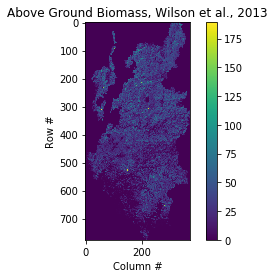

In [430]:
plt.imshow(band1)
plt.colorbar()
plt.title('Above Ground Biomass, Wilson et al., 2013')
plt.xlabel('Column #')
plt.ylabel('Row #')

In [431]:
# Fill in the 0 values with nan for the AGB tif file
with rs.open(agb_in + "carbon_ag_mg_boisenf.tif") as src:
    agb = src.read(1)

agb[agb==0] = np.nan

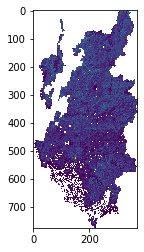

In [432]:
plt.imshow(agb)

## Let's Make Some Plots

Mostly histograms and some scatter plots. 

### First the FIA Data


#### Since we are testing out single point runs, let's focus on the south-east region first.

In [433]:
se_lp = fia_se.loc[(fia_se['SPECIES']=='lodge_pine')].copy()
se_pipo = fia_se.loc[(fia_se['SPECIES']=='pondo_pine')].copy()
se_wp = fia_se.loc[(fia_df['SPECIES']=='w_whitepine')].copy()
se_doug = fia_se.loc[(fia_df['SPECIES']=='doug-fir')].copy()
se_whem = fia_se.loc[(fia_df['SPECIES']=='w_hem')].copy()

se_lp_d = se_lp['DIA'].values 
se_pipo_d = se_pipo['DIA'].values
se_wp_d = se_wp['DIA'].values
sedoug_d = se_doug['DIA'].values 
sewhem_d = se_whem['DIA'].values 

se_lp_h = se_lp['HT'].values 
se_pipo_h = se_pipo['HT'].values 
se_wp_h = se_wp['HT'].values
sedoug_h = se_doug['HT'].values 
sewhem_h = se_whem['HT'].values 


Text(0.5, 0.98, 'FIA Height Distribution in SE Idaho')

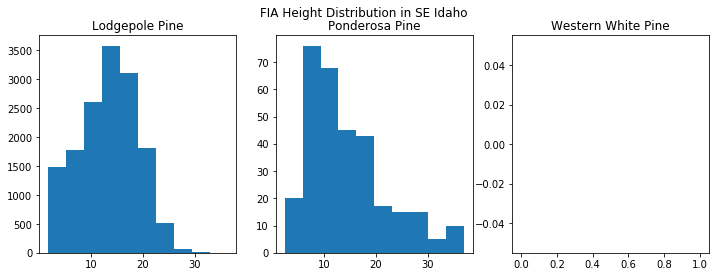

In [434]:
# Pines (PFT 1)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].hist(se_lp_h)
axs[0].set_title("Lodgepole Pine")
axs[1].hist(se_pipo_h)
axs[1].set_title("Ponderosa Pine")
axs[2].hist(se_wp_h)
axs[2].set_title("Western White Pine")

fig.suptitle('FIA Height Distribution in SE Idaho')

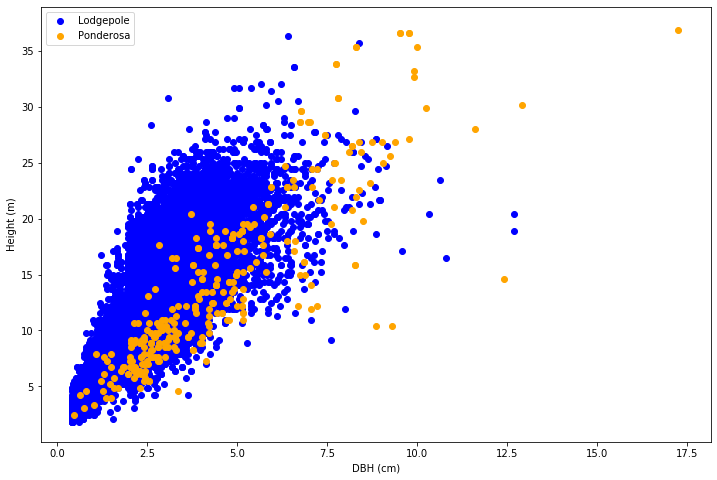

In [435]:
# Make a nice function to split out some data by each species and plot
# height vs dbh, AGB vs dbh, crown area vs dbh 

fig = plt.figure(figsize = (12,8))

plt.scatter(se_lp_d, se_lp_h, color='b', label = "Lodgepole")
plt.scatter(se_pipo_d, se_pipo_h, color='orange', label = "Ponderosa")
plt.xlabel("DBH (cm)")
plt.ylabel("Height (m)")
plt.legend()
plt.show()

/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0.98, 'FIA Height Distribution in SE Idaho')

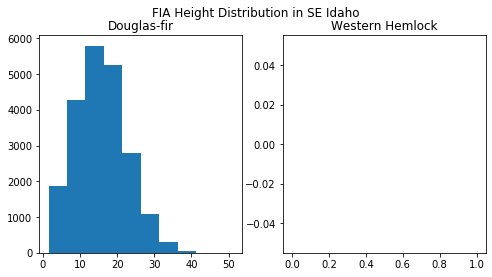

In [436]:
# Doug-fir and W. Hemlock (PFT 4)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].hist(sedoug_h)
axs[0].set_title("Douglas-fir")
axs[1].hist(sewhem_h)
axs[1].set_title("Western Hemlock")

fig.suptitle('FIA Height Distribution in SE Idaho')

Text(0.5, 0.98, 'FIA Height Distribution in SE Idaho')

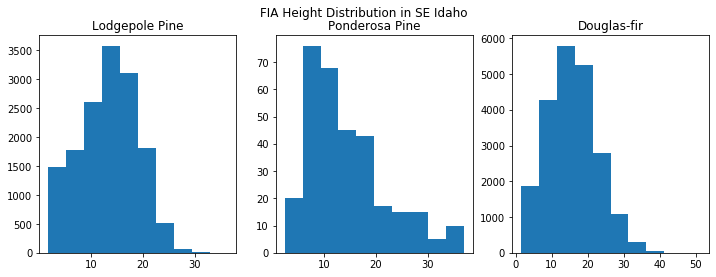

In [437]:
# Pines (PFT 1)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].hist(se_lp_h)
axs[0].set_title("Lodgepole Pine")
axs[1].hist(se_pipo_h)
axs[1].set_title("Ponderosa Pine")
axs[2].hist(sedoug_h)
axs[2].set_title("Douglas-fir")

fig.suptitle('FIA Height Distribution in SE Idaho')

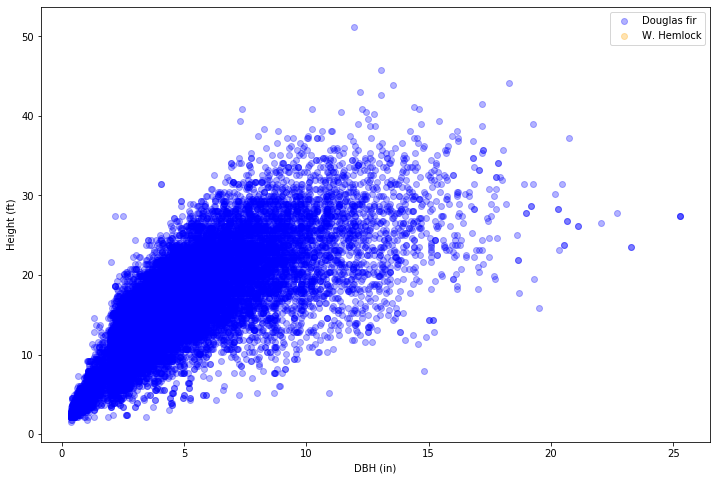

In [438]:
fig = plt.figure(figsize = (12,8))

plt.scatter(sedoug_d, sedoug_h, color='b',  alpha = 0.3, label = "Douglas fir")
plt.scatter(sewhem_d, sewhem_h, color='orange',  alpha = 0.3, label = "W. Hemlock")
plt.xlabel("DBH (in)")
plt.ylabel("Height (ft)")
plt.legend()
plt.show()

#### Investigate the diameter to height for all of Idaho

In [439]:
# Create dataframes and arrays for the desired species and variables

#Dataframes by species
df_lp = fia_df.loc[(fia_df['SPECIES']=='lodge_pine')].copy()
df_pipo = fia_df.loc[(fia_df['SPECIES']=='pondo_pine')].copy()
df_wp = fia_df.loc[(fia_df['SPECIES']=='w_whitepine')].copy()
df_doug = fia_df.loc[(fia_df['SPECIES']=='doug-fir')].copy()
df_whem = fia_df.loc[(fia_df['SPECIES']=='w_hem')].copy()

#DBH in cm
lp_d = df_lp['DIA'].values 
pipo_d = df_pipo['DIA'].values 
wp_d = df_wp['DIA'].values 
doug_d = df_doug['DIA'].values
whem_d = df_whem['DIA'].values

#Height in m
lp_h = df_lp['HT'].values 
pipo_h = df_pipo['HT'].values 
wp_h = df_wp['HT'].values 
doug_h = df_doug['HT'].values
whem_h = df_whem['HT'].values 

#Carbon above ground (CARBON_AG) by tree (lbC/tree)
lp_cag = df_lp['CARBON_AG'].values
pipo_cag = df_pipo['CARBON_AG'].values
wh_cag = df_wh['CARBON_AG'].values 
doug_cag = df_doug['CARBON_AG'].values 
whem_cag = df_whem['CARBON_AG'].values

#Carbon above ground (AGB) by tree (gC/tree)
lp_agb2 = df_lp['AGB2'].values
pipo_agb2 = df_pipo['AGB2'].values
#wh_agb2 = df_wh['AGB2'].values #This must be a bug. There are CARBON_AG values so there have to be AGB2 values.
doug_agb2 = df_doug['AGB2'].values 
whem_agb2 = df_whem['AGB2'].values 

#Carbon above ground (AGB) by area (gC/m^2)
lp_agb = df_lp['AGB'].values
pipo_agb = df_pipo['AGB'].values
wh_agb = df_wh['AGB'].values 
doug_agb = df_doug['AGB'].values 
whem_agb = df_whem['AGB'].values 


Text(0.5, 0.98, 'FIA Height Distribution in Idaho')

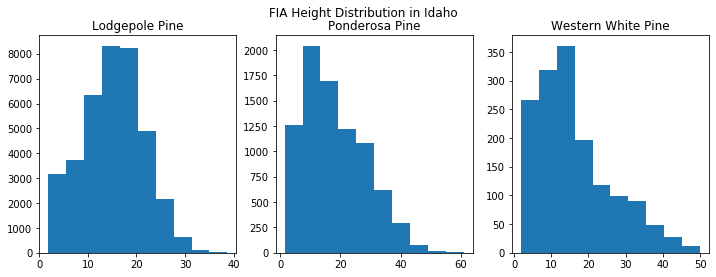

In [440]:
# Pines (PFT 1)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].hist(lp_h)
axs[0].set_title("Lodgepole Pine")
axs[1].hist(pipo_h)
axs[1].set_title("Ponderosa Pine")
axs[2].hist(wp_h)
axs[2].set_title("Western White Pine")

fig.suptitle('FIA Height Distribution in Idaho')

Text(0.5, 0.98, 'FIA Height Distribution in Idaho')

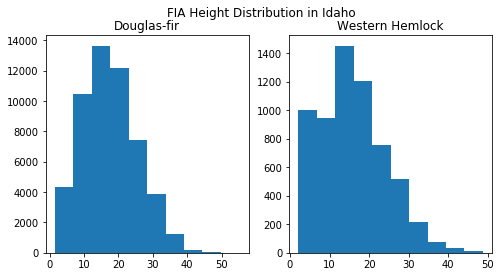

In [441]:
# Doug-fir and W. Hemlock (PFT 4)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].hist(doug_h)
axs[0].set_title("Douglas-fir")
axs[1].hist(whem_h)
axs[1].set_title("Western Hemlock")

fig.suptitle('FIA Height Distribution in Idaho')

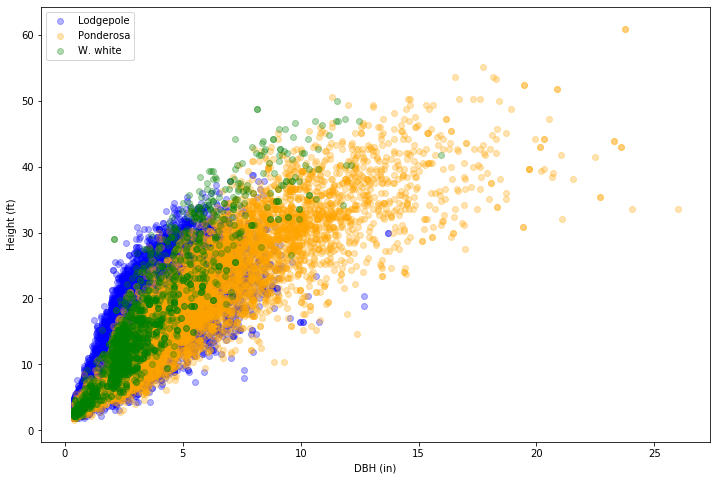

In [442]:
# Here are the pines, which will make up PFT 1.
# Scatter plots for all Idaho pines (pondo, lodge, white)
# These are shade intolorant, low specific gravity <0.4

fig = plt.figure(figsize = (12,8))

plt.scatter(lp_d, lp_h, color='b', alpha = 0.3, label = "Lodgepole")
plt.scatter(pipo_d, pipo_h, color='orange',  alpha = 0.3, label = "Ponderosa")
plt.scatter(wp_d, wp_h, color='green',  alpha = 0.3, label = "W. white")
plt.xlabel("DBH (in)")
plt.ylabel("Height (ft)")
plt.legend()
plt.show()

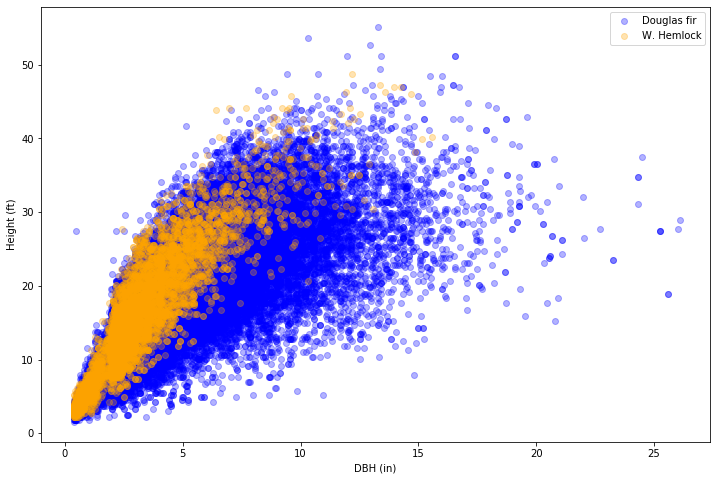

In [443]:
# These two species will represent PFT 4. 
# Scatter plots for all Idaho W. hemlock and Douglas fir
# These are shade tolorant, high specific gravity >0.4

fig = plt.figure(figsize = (12,8))

plt.scatter(doug_d, doug_h, color='b',  alpha = 0.3, label = "Douglas fir")
plt.scatter(whem_d, whem_h, color='orange',  alpha = 0.3, label = "W. Hemlock")
plt.xlabel("DBH (in)")
plt.ylabel("Height (ft)")
plt.legend()
plt.show()

#### Investigate the diameter to biomass

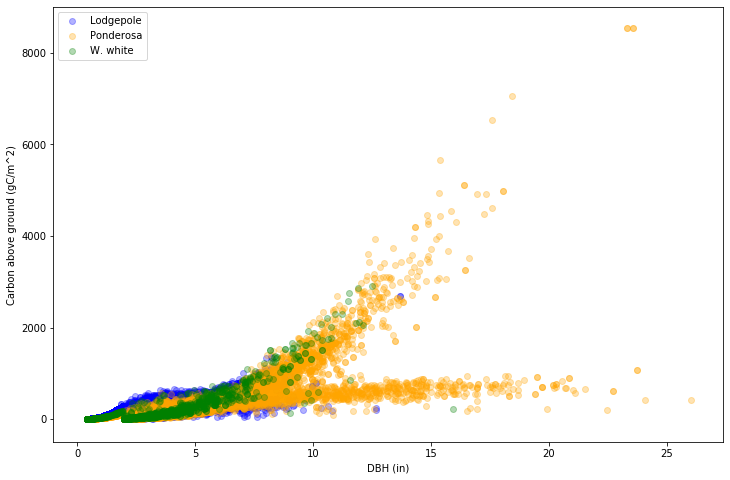

In [444]:
# Scatter plots for all Idaho pines (pondo, lodge, white)
# These are shade intolorant, low specific gravity <0.4
# Above ground C in pounds and excluding foliage

fig = plt.figure(figsize = (12,8))

plt.scatter(lp_d, lp_agb, color='b', alpha = 0.3, label = "Lodgepole")
plt.scatter(pipo_d, pipo_agb, color='orange',  alpha = 0.3, label = "Ponderosa")
plt.scatter(wh_d, wh_agb, color='green',  alpha = 0.3, label = "W. white")
plt.xlabel("DBH (in)")
plt.ylabel("Carbon above ground (gC/m^2)")
plt.legend()
plt.show()

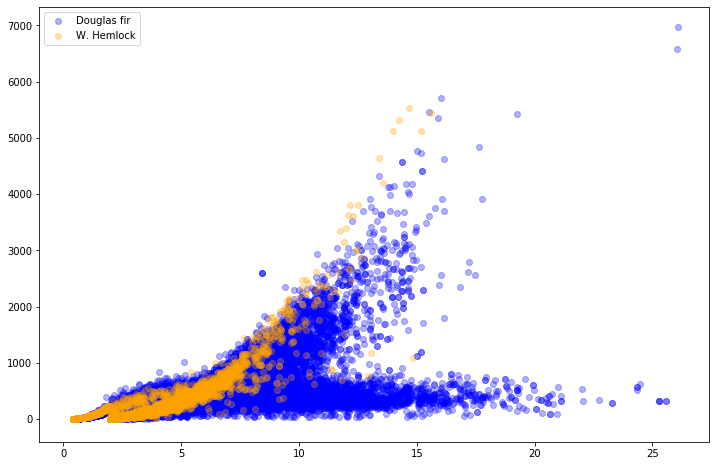

In [445]:
# Scatter plots for all Idaho W. hemlock and Douglas fir
# These are shade tolorant, high specific gravity >0.4

fig = plt.figure(figsize = (12,8))
 
plt.scatter(doug_d, doug_agb, color='b',  alpha = 0.3, label = "Douglas fir")
plt.scatter(whem_d, whem_agb, color='orange',  alpha = 0.3, label = "W. Hemlock")
plt.legend()
plt.show()

#### Something strange happens when going from per tree to per m^2?



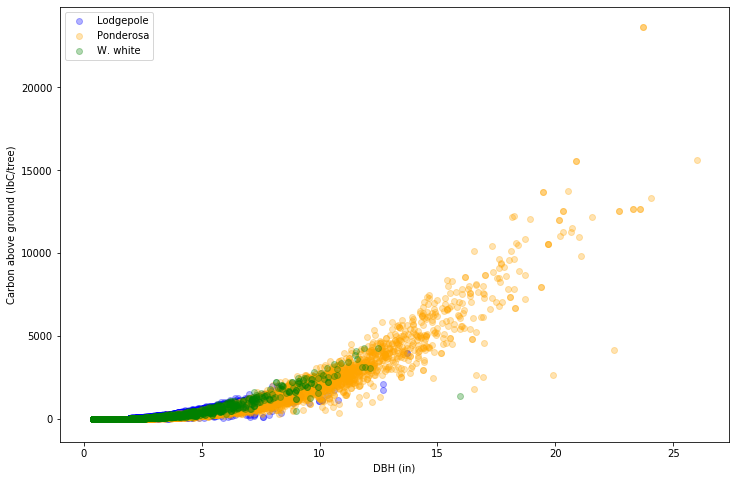

In [446]:
# Scatter plots for all Idaho pines (pondo, lodge, white)
# These are shade intolorant, low specific gravity <0.4
# Above ground C in pounds and excluding foliage

fig = plt.figure(figsize = (12,8))

plt.scatter(lp_d, lp_cag, color='b', alpha = 0.3, label = "Lodgepole")
plt.scatter(pipo_d, pipo_cag, color='orange',  alpha = 0.3, label = "Ponderosa")
plt.scatter(wh_d, wh_cag, color='green',  alpha = 0.3, label = "W. white")
plt.xlabel("DBH (in)")
plt.ylabel("Carbon above ground (lbC/tree)")
plt.legend()
plt.show()

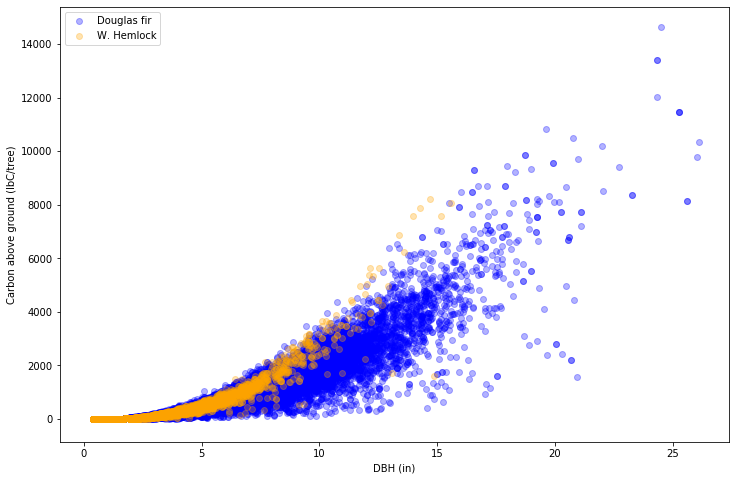

In [447]:
# Scatter plots for all Idaho W. hemlock and Douglas fir
# These are shade tolorant, high specific gravity >0.4

fig = plt.figure(figsize = (12,8))
 
plt.scatter(doug_d, doug_cag, color='b',  alpha = 0.3, label = "Douglas fir")
plt.scatter(whem_d, whem_cag, color='orange',  alpha = 0.3, label = "W. Hemlock")
plt.xlabel("DBH (in)")
plt.ylabel("Carbon above ground (lbC/tree)")
plt.legend()
plt.show()

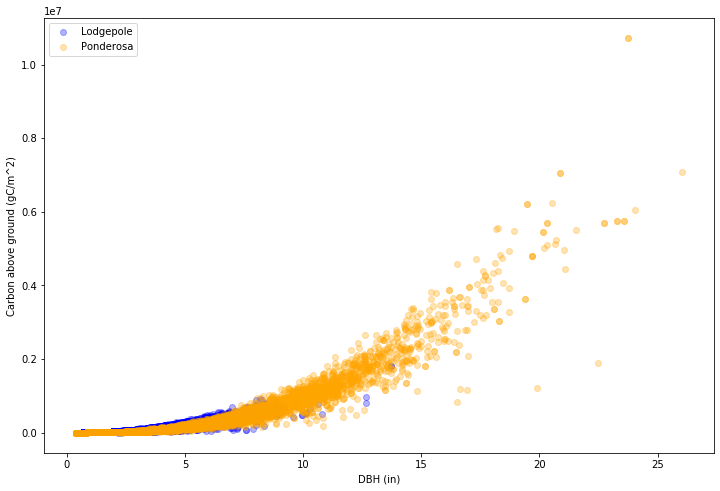

In [448]:
# Scatter plots for all Idaho pines (pondo, lodge, white)
# These are shade intolorant, low specific gravity <0.4
# Above ground C in pounds and excluding foliage

fig = plt.figure(figsize = (12,8))

plt.scatter(lp_d, lp_agb2, color='b', alpha = 0.3, label = "Lodgepole")
plt.scatter(pipo_d, pipo_agb2, color='orange',  alpha = 0.3, label = "Ponderosa")
#plt.scatter(wh_d, wh_agb2, color='green',  alpha = 0.3, label = "W. white")
plt.xlabel("DBH (in)")
plt.ylabel("Carbon above ground (gC/m^2)")
plt.legend()
plt.show()

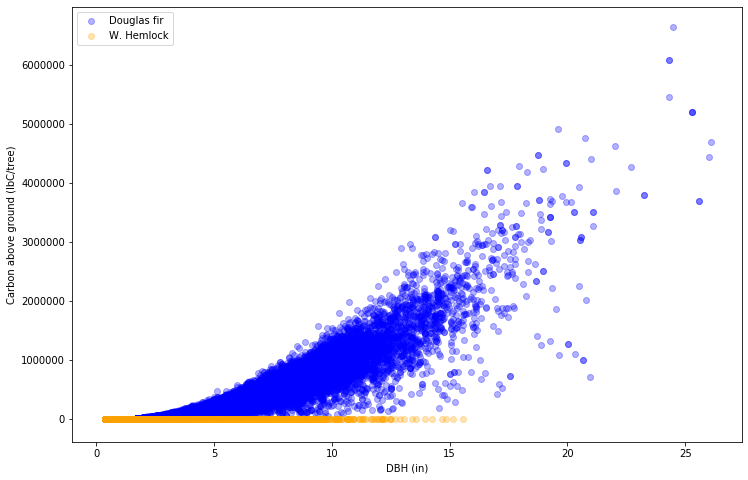

In [449]:
# Scatter plots for all Idaho W. hemlock and Douglas fir
# These are shade tolorant, high specific gravity >0.4

fig = plt.figure(figsize = (12,8))
 
plt.scatter(doug_d, doug_agb2, color='b',  alpha = 0.3, label = "Douglas fir")
plt.scatter(whem_d, whem_cag, color='orange',  alpha = 0.3, label = "W. Hemlock")
plt.xlabel("DBH (in)")
plt.ylabel("Carbon above ground (lbC/tree)")
plt.legend()
plt.show()

#### Investigate mean diameter to mean basal area

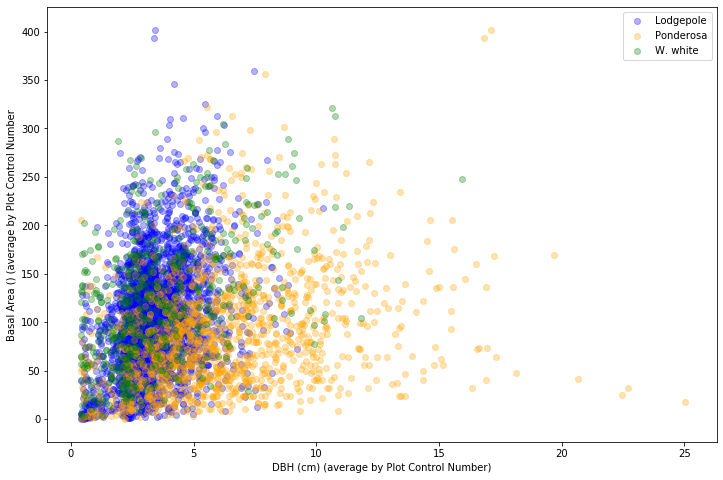

In [450]:
# Scatter plots for all Idaho pines (pondo, lodge, white)
# These are shade intolorant, low specific gravity <0.4
# Above ground C in pounds and excluding foliage

fig = plt.figure(figsize = (12,8))

lp_ba = df_lp['BALIVE'].values 
lp_mu = df_lp.groupby('PLT_CN').mean()
lp_ba_mu = lp_mu['BALIVE'].values
lp_d_mu = lp_mu['DIA'].values

pipo_ba = df_pipo['BALIVE'].values 
pipo_mu = df_pipo.groupby('PLT_CN').mean()
pipo_ba_mu = pipo_mu['BALIVE'].values
pipo_d_mu = pipo_mu['DIA'].values

wh_ba = df_wh['BALIVE'].values 
wh_mu = df_wh.groupby('PLT_CN').mean()
wh_ba_mu = wh_mu['BALIVE'].values
wh_d_mu = wh_mu['DIA'].values

plt.scatter(lp_d_mu, lp_ba_mu, color='b', alpha = 0.3, label = "Lodgepole")
plt.scatter(pipo_d_mu, pipo_ba_mu, color='orange',  alpha = 0.3, label = "Ponderosa")
plt.scatter(wh_d_mu, wh_ba_mu, color='green',  alpha = 0.3, label = "W. white")
plt.xlabel('DBH (cm) (average by Plot Control Number)')
plt.ylabel('Basal Area () (average by Plot Control Number')
plt.legend()
plt.show()

Text(0.5, 0.98, 'FIA Mean Basal Area by Plot Distribution in Idaho')

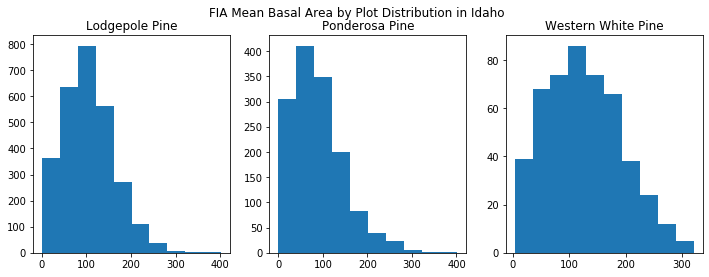

In [347]:
# Pines (PFT 1)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].hist(lp_ba_mu)
axs[0].set_title("Lodgepole Pine")
axs[1].hist(pipo_ba_mu)
axs[1].set_title("Ponderosa Pine")
axs[2].hist(wh_ba_mu)
axs[2].set_title("Western White Pine")

fig.suptitle('FIA Mean Basal Area by Plot Distribution in Idaho')


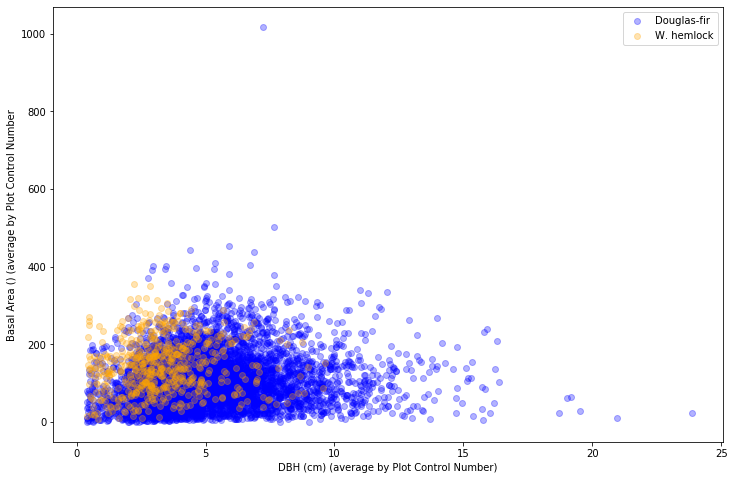

In [452]:
# Scatter plots for all Idaho pines (pondo, lodge, white)
# These are shade intolorant, low specific gravity <0.4
# Above ground C in pounds and excluding foliage

fig = plt.figure(figsize = (12,8))

doug_ba = df_doug['BALIVE'].values 
doug_mu = df_doug.groupby('PLT_CN').mean()
doug_ba_mu = doug_mu['BALIVE'].values
doug_d_mu = doug_mu['DIA'].values

whem_ba = df_whem['BALIVE'].values 
whem_mu = df_whem.groupby('PLT_CN').mean()
whem_ba_mu = whem_mu['BALIVE'].values
whem_d_mu = whem_mu['DIA'].values

plt.scatter(doug_d_mu, doug_ba_mu, color='b', alpha = 0.3, label = "Douglas-fir")
plt.scatter(whem_d_mu, whem_ba_mu, color='orange',  alpha = 0.3, label = "W. hemlock")
plt.xlabel('DBH (cm) (average by Plot Control Number)')
plt.ylabel('Basal Area () (average by Plot Control Number')
plt.legend()
plt.show()

Text(0.5, 0.98, 'FIA Mean Basal Area by Plot Distribution in Idaho')

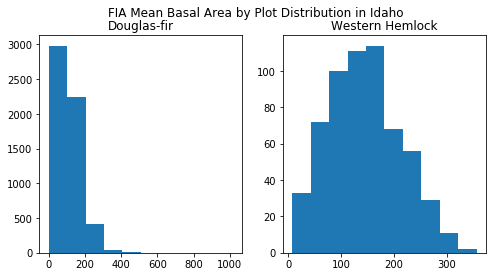

In [453]:
# Doug-fir and W. Hemlock (PFT 4)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].hist(doug_ba_mu)
axs[0].set_title("Douglas-fir")
axs[1].hist(whem_ba_mu)
axs[1].set_title("Western Hemlock")

fig.suptitle('FIA Mean Basal Area by Plot Distribution in Idaho')

### Aboveground Biomass from Wilson et al., 2013

minimum =  0.0 maximum =  189.09554 mean =  13.999346


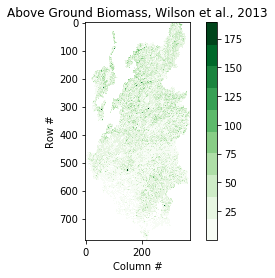

In [372]:
plt.imshow(agb, cmap = plt.cm.get_cmap('Greens', 10))
plt.colorbar()
plt.title('Above Ground Biomass, Wilson et al., 2013')
plt.xlabel('Column #')
plt.ylabel('Row #')

print("minimum = ", band1.min(),"maximum = ", band1.max(), "mean = ",band1.mean())

In [390]:
print("agb dtype = ", type(agb), "band1 dtype = ", type(band1))

agb dtype =  <class 'numpy.ndarray'> band1 dtype =  <class 'numpy.ndarray'>


In [393]:
# Create a Data Array with xarray to help create a histogram of the AGB data
# Keep it simple: set the data to agb, set the dims to x and y

agb_da = xr.DataArray(data=agb,
                     dims=["x", "y"],
                     )
agb_da

<xarray.DataArray (x: 776, y: 372)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Dimensions without coordinates: x, y

(array([5.1929e+04, 6.5841e+04, 2.9090e+04, 4.6900e+03, 6.9600e+02,
        1.6100e+02, 1.8000e+01, 3.7000e+01, 2.0000e+01, 2.9000e+01]),
 array([4.0125707e-03, 1.8913164e+01, 3.7822315e+01, 5.6731468e+01,
        7.5640625e+01, 9.4549774e+01, 1.1345892e+02, 1.3236807e+02,
        1.5127724e+02, 1.7018639e+02, 1.8909554e+02], dtype=float32),
 <a list of 10 Patch objects>)

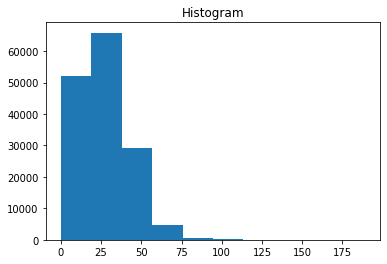

In [395]:
# Plot a histogram of AGB using xarray

xr.plot.hist(agb_da)

### Next, create some plots of the MODIS data

Here I have two sets of data. One set is from a small region, the Bear Run area of the Boise Basin Experimental Forest (eg. lai_br), and one is from a single point selection (eg. lai_sp). 

* br is still small, roughly the size of the single point, which is about 11$km^2$

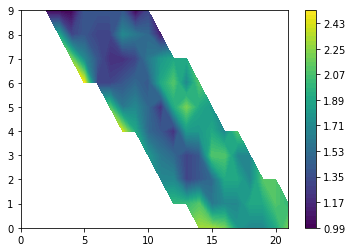

In [84]:
# Check NPP 

plt.contourf(lai_br['Lai_500m'][0,:,:], 50)
plt.colorbar()

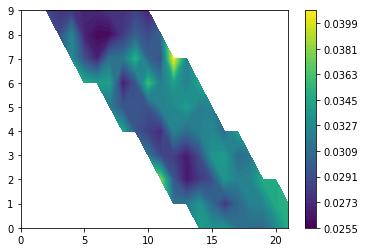

In [85]:
# Check GPP 

plt.contourf(gpp_br['Gpp_500m'][0,:,:], 50)
plt.colorbar()

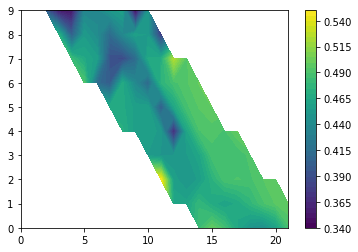

In [54]:
# Check NPP 

plt.contourf(npp_br['Npp_500m'][0,:,:], 50)
plt.colorbar()

In [55]:
lai_br.head(2)
lai_br['Lai_500m'].shape

(19, 10, 22)

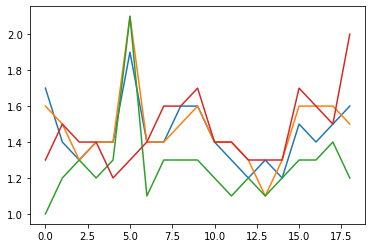

In [106]:
# LAI on y-axis, time in years on the x-axis. 
# I need finer temporal resolution data so that I can see the seasonal trends.
# For now just the histograms will have to suffice.
plt.plot(lai_br['Lai_500m'][:,8,8])
plt.plot(lai_br['Lai_500m'][:,8,9])
plt.plot(lai_br['Lai_500m'][:,9,9])
plt.plot(lai_br['Lai_500m'][:,9,10])
#plt.plot(lai_br['Lai_500m'][:,8,12])

(array([  2., 218., 802., 561., 157.,  36.,  22.,   2.,   2.,   3.]),
 array([0.3       , 0.84000003, 1.3800001 , 1.9200001 , 2.46      ,
        3.0000002 , 3.5400002 , 4.0800004 , 4.6200004 , 5.1600003 ,
        5.7000003 ], dtype=float32),
 <a list of 10 Patch objects>)

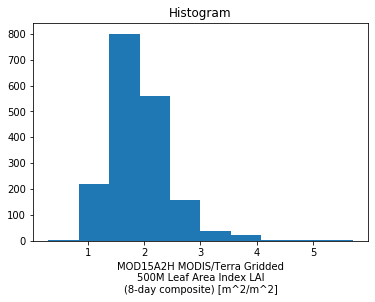

In [553]:
# Check out the LAI for the Bear Run area of BBEF

lai_br['Lai_500m'].plot()

(array([  6.,  89., 208., 271., 350., 303., 310., 201.,  58.,   9.]),
 array([0.0107 , 0.01691, 0.02312, 0.02933, 0.03554, 0.04175, 0.04796,
        0.05417, 0.06038, 0.06659, 0.0728 ], dtype=float32),
 <a list of 10 Patch objects>)

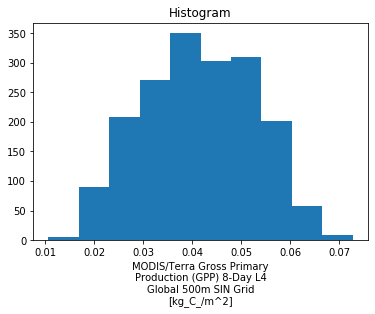

In [58]:
# Check out the GPP for the Bear Run area of BBEF

gpp_br['Gpp_500m'].plot()

(array([ 44., 225., 478., 328., 219., 216., 193.,  78.,  19.,   5.]),
 array([0.3446    , 0.38143998, 0.41828   , 0.45512   , 0.49196   ,
        0.5288    , 0.56564   , 0.60248   , 0.63932   , 0.67616   ,
        0.713     ], dtype=float32),
 <a list of 10 Patch objects>)

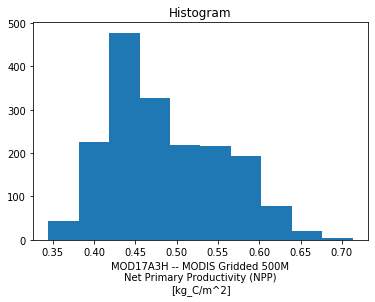

In [400]:
# Check out the NPP for the Bear Run area of BBEF

npp_br['Npp_500m'].plot()

Text(0.5, 0, 'LAI ($m^2/m^2$)')

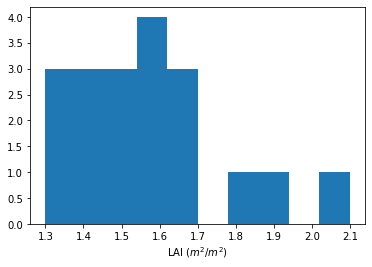

In [397]:
# Check out LAI from the single point

plt.hist(lai_sp['MOD15A2H_006_Lai_500m'])
plt.xlabel("LAI ($m^2/m^2$)")

Text(0.5, 0, 'GPP ($kgC/m^2)')

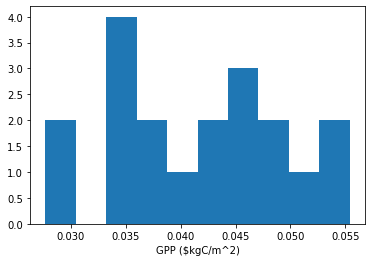

In [398]:
# Check out GPP from the single point

plt.hist(gpp_sp['MOD17A2H_006_Gpp_500m'])
plt.xlabel("GPP ($kgC/m^2)")

Text(0.5, 0, 'NPP ($kgC/m^2)')

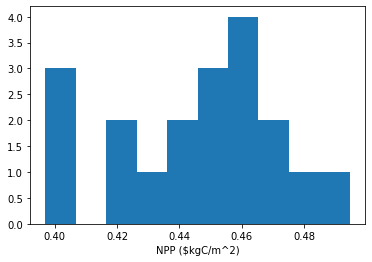

In [399]:
# Check out NPP from the single point

plt.hist(npp_sp['MOD17A3HGF_006_Npp_500m'])
plt.xlabel("NPP ($kgC/m^2)")

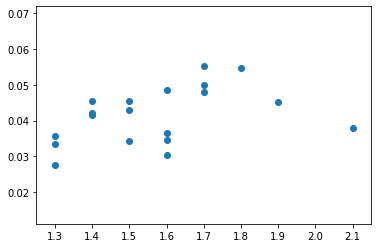

In [102]:
plt.scatter(lai_sp['MOD15A2H_006_Lai_500m'], gpp_sp['MOD17A2H_006_Gpp_500m'])

#### Now for the FVS data

In [261]:
fvs_df.head(1)

,OBJECTID,STAND_CN,ACRES,Fire_Regime,Notes,PCT_PP_L_2016,PCT_DF_L_2016,Size_Class_2016,CC_ALL_2016,CC_PP_T_2016,CC_DF_T_2016,Area_m2
0,1,4.466501e+10,210.923701,Non-lethal,,89.26,10.74,Large,57.1,29.11,39.49,853578.688629


In [262]:
# Take only size class == Small, Medium, or Large
# No sapling

fvs_sml = fvs_df.loc[(fvs_df['Size_Class_2016'] == "Small") | (fvs_df['Size_Class_2016'] == "Medium") | (fvs_df['Size_Class_2016'] == "Large")].copy()
fvs_sml.head(2)

,OBJECTID,STAND_CN,ACRES,Fire_Regime,Notes,PCT_PP_L_2016,PCT_DF_L_2016,Size_Class_2016,CC_ALL_2016,CC_PP_T_2016,CC_DF_T_2016,Area_m2
0,1,4.466501e+10,210.923701,Non-lethal,,89.26,10.74,Large,57.10,29.11,39.49,853578.688629
1,2,4.464801e+10,62.242111,Non-lethal,,100.00,0.00,Large,49.13,39.08,16.49,251885.109321


(array([11.,  4.,  2.,  6.,  3., 13.,  8.,  8., 12., 81.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

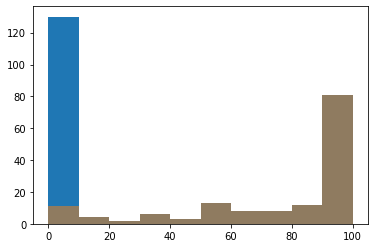

In [263]:
plt.hist(fvs_df['PCT_PP_L_2016'])
plt.hist(fvs_sml['PCT_PP_L_2016'], alpha = 0.5)

(array([88., 13.,  8., 10., 12.,  3.,  6.,  4.,  1.,  3.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

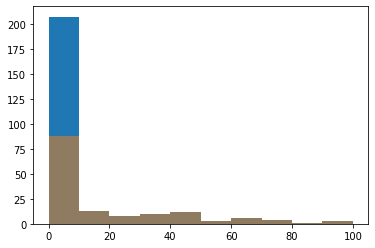

In [264]:
plt.hist(fvs_df['PCT_DF_L_2016'])
plt.hist(fvs_sml['PCT_DF_L_2016'], alpha = 0.5)

(array([11.,  7., 18., 20., 39., 28., 11.,  9.,  4.,  1.]),
 array([ 0.19 ,  6.896, 13.602, 20.308, 27.014, 33.72 , 40.426, 47.132,
        53.838, 60.544, 67.25 ]),
 <a list of 10 Patch objects>)

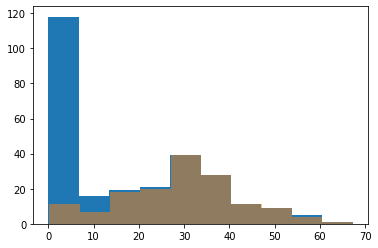

In [265]:
plt.hist(fvs_df['CC_PP_T_2016'])
plt.hist(fvs_sml['CC_PP_T_2016'], alpha = 0.5)

(array([60., 18., 14.,  8., 13., 14.,  5., 13.,  0.,  3.]),
 array([3.000e-02, 6.200e+00, 1.237e+01, 1.854e+01, 2.471e+01, 3.088e+01,
        3.705e+01, 4.322e+01, 4.939e+01, 5.556e+01, 6.173e+01]),
 <a list of 10 Patch objects>)

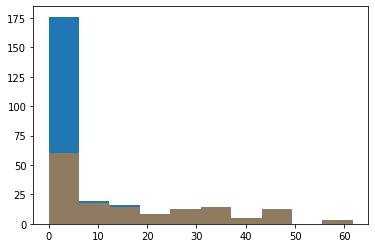

In [266]:
plt.hist(fvs_df['CC_DF_T_2016'])
plt.hist(fvs_sml['CC_DF_T_2016'], alpha = 0.5)

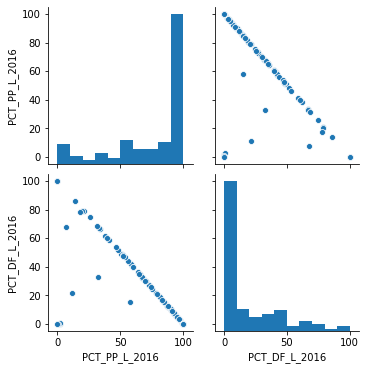

In [37]:
sns.pairplot(fvs_sml.reset_index(), vars =['PCT_PP_L_2016','PCT_DF_L_2016'] )

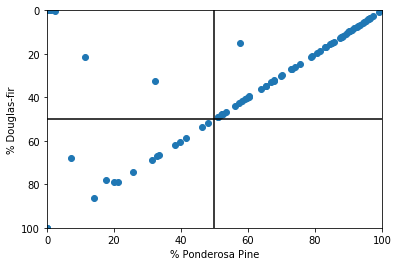

In [53]:
pct_pp = fvs_sml['PCT_PP_L_2016'].values
pct_df = fvs_sml['PCT_DF_L_2016'].values

plt.gca().invert_yaxis()
plt.scatter(pct_pp, pct_df)
plt.xlim(0,100)
plt.ylim(0,100)
plt.vlines(50, 0, 100)
plt.hlines(50, 0 , 100)
plt.xlabel("% Ponderosa Pine")
plt.ylabel("% Douglas-fir")
plt.gca().invert_yaxis()

# I thought this would look better...

### Cost Functions

Here I am creating $r^2$, RMSE, and z-score functions and testing them with predicted heights.

In [534]:
# Define r^2 and RMSE cost functions

# Define r^2
def r2(y_act, y_pred):
    corr_matrix = np.corrcoef(y_act, y_pred)
    corr_yy = corr_matrix[0,1]
    r2 = corr_yy**2
    print("R squared:\n")
    return r2


# Define RMSE function 
def RMSE(y_act, y_pred):
    MSE = np.square(np.subtract(y_act, y_pred).mean())
    RMSE = math.sqrt(MSE)
    print("Root Mean Square Error:\n")
    return RMSE

# Define z-score function
def zscore(y_act, y_pred, ran): 
    zscore = []
    act_mu = y_act.mean()
    act_std = np.std(y_act)
    pred = y_pred
    for i in ran:
        z = (y_pred[i] - act_mu) / act_std
        
        zscore.append(z)
    print("Z-score:\n")
    return zscore

# Define distance score
def dscore(y_act, y_pred):
    obs_min = min(y_act)
    obs_max = max(y_act)
    MSE = np.square(np.subtract(y_act, y_pred).mean())
    RMSE = math.sqrt(MSE)
    dscore = RMSE/(obs_max-obs_min)
    #print("Distance score (RMSE/Observed Range):\n")
    return dscore
        

In [535]:
y_pred = np.array([2,4,5,6,2,3,7,1,3,4])
y_act = np.array([2,3,3,4,4,5,5,2,3,5])

ran = np.arange(0,4,1)

0
1
2
3
10 10


In [536]:
zscore(y_act, y_pred, ran)

Z-score:



[-1.4368424162141993,
 0.3592106040535497,
 1.2572371141874241,
 2.155263624321299]

In [537]:
dscore(y_act, y_pred)

0.03333333333333333

In [538]:
bbef.head(2)

,BBEF Study-name,Year,Plot ID,Tree ID,Species,DBH (inches),Height (feet),DBH (cm),H (m),AGB
0,Amber Fuels,2013,451,1,Ponderosa pine,31.600000,127.0,80.264000,38.7096,7.961826
1,Amber Fuels,2013,451,2,Ponderosa pine,20.700001,102.0,52.578003,31.0896,5.063293


In [539]:
# Define diameter to height function from O'Brien et al., 1995. See SCGSR Target Allometry for more allometry
# and parameter optimization fun. 

def d2h(dbh,p1,p2):
    h = 10**((np.log10(dbh))*p1+p2)
    return h

def carea_2pwr(d, p1, p2):
    c = p1 * d ** p2
    return(c)

In [540]:
h_actual = bbef['H (m)'].values
h_actual

array([38.7096, 31.0896, 24.0792, ..., 29.2608, 34.4424, 37.1856])

In [541]:
h_pred = []

dbh = bbef['DBH (cm)'].values

for i in dbh:
    test = d2h(i, 0.64, 0.37)
    h_pred.append(test)
    
# Check the output
#h_pred

In [542]:
#Calculate the RMSE
RMSE(h_actual, h_pred)

Root Mean Square Error:



1.6994578142523855

In [543]:
#Calculate r2
r2(h_actual, h_pred)

R squared:



0.7457968669240809

The O'Brien function does an ok job of predicting heights from DBH at BBEF. 

In [544]:
#Calculate zscore
zscore(h_actual, h_pred, ran)

Z-score:



[2.271681201514147, 1.337109993778001, 1.176699597377253, 0.9712101140052157]

In [547]:
# Calculate distance score
# This is most useful for comparing different variables
# Predict height data

h_pred = []

dbh = bbef['DBH (cm)'].values

for i in dbh:
    test = d2h(i, 0.64, 0.37)
    h_pred.append(test)

# so make some fake project crown area data to play with.

c_pred = []
c_act = []

dbh = bbef['DBH (cm)'].values

for i in dbh:
    test = carea_2pwr(i, 0.06375559, 1.54726309)
    c_pred.append(test)
for i in dbh:
    test = carea_2pwr(i, 0.07, 1.25)
    c_act.append(test) 

h_dscore = dscore(h_actual, h_pred)
carea_dscore = dscore(c_act, c_pred)

print("dscores: \n", h_dscore, carea_dscore)

dscores: 
 0.0063144382750747775 0.09839303293601906


In [305]:
# Lets compare the BBEF to FIA for SE Idaho. Why though? 
print(len(fia_se['HT']), len(bbef['H (m)']))

61356 5523


In [311]:
# First randomly sample 50 values each from the two data sets

h_bbef = bbef['H (m)'].values
h_fia = fia_se['HT'].values

rh_bbef = np.random.choice(h_bbef, 50, replace=True)
rh_fia = np.random.choice(h_fia, 50, replace=False)

smp_bbef = bbef.sample(50)
smp_fia = fia_se.sample(50)

print(rh_bbef.mean(), rh_fia.mean())
print(smp_bbef['H (m)'].mean(), smp_fia['HT'].mean())

14.8425408 10.984992000000002
16.812768000000002 12.649200000000006


In [312]:
RMSE(rh_bbef, rh_fia)

Root Mean Square Error:



12.940982443758433

In [313]:
RMSE(smp_bbef['H (m)'].values, smp_fia['HT'].values)

Root Mean Square Error:



13.967971399475875

In [314]:
r2(rh_bbef, rh_fia)

R squared:



0.05635473932295694

In [318]:
r2(smp_bbef['H (m)'], smp_fia['HT'])

R squared:



0.01372295029255089

In [317]:
print(rh_bbef.min(), rh_fia.min())
print(smp_bbef['H (m)'].min(), smp_fia['HT'].min())

0.3048 2.1336
2.1336 2.4384


#### Taylor Diagram Testing

Taken from https://metclim.ucd.ie/2020/06/taylor-diagrams-and-high-resolution-plots-of-land-use-and-elevation/

A Taylor Diagram will be useful for comparing the various model outputs (GPP, NPP, LAI, Heights, Basal Area, and AGB) from the 100 FATES parameterizations. 

Below is an example using predicted heights from diameter at breat height. The target data in this case are the observed height from the Boise Basin Experimental Forest (BBEF). From the observed data we get the standard deviation plotted as a cyan/blue colored line. 

In [290]:
# function for generating circles on a graph

def drawCircle(radius, xcenter=0, ycenter=0, maxradius=np.inf,style="--", color="k", lw=1, label=""):
    angles = np.linspace(-np.pi / 2, np.pi / 2, 361)
    x = np.sin(angles) * radius + xcenter
    y = np.cos(angles) * radius + ycenter

  # Only keep points within the circle
    I = np.where(x ** 2 + y ** 2 < maxradius ** 2)[0]
    if(len(I) == 0):
        return
    x = x[I]
    y = y[I]
    plt.plot(x, y, style, color=color, lw=lw, zorder=-100, label=label)
    plt.plot(x, -y, style, color=color, lw=lw, zorder=-100)

In [291]:
# function for pulling all the data together, draws the circles, and creates the plot

def makeTaylor(corrs,stds,stdobs,circ_LIM=1.0,loc='location'):
    '''This function takes a list of correlations and standard deviations 
       corresponding to 6 different model outputs in this case (should alter 
       the code for your application), along with the standard deviation
       of the observations. circ_LIM determines the radius of the outer
       circle in the plot and loc is a name identifier (like station name)
       for plot titles and filenames for saving plots
    '''


    #plot_colors = ['blue','purple','brown','orange','green','red']
    plot_colors = ['blue', 'orange', 'red']
    ang = np.arccos(corrs)
    x = stds * np.cos(ang)
    y = stds * np.sin(ang)
    
    fig, axs = plt.subplots(1, 1,figsize=(8,8))

    #plt.scatter(x[:3], y[:3], marker='o',s=120, color=plot_colors[:3],edgecolor='k', label=plot_colors)
    #plt.scatter(x[3:], y[3:], marker='X',s=180, color=plot_colors[3:],edgecolor='k', label=plot_colors)
    
    plt.scatter(x[:3], y[:3], marker='o',s=120, color=plot_colors[:3],edgecolor='k')
    plt.scatter(x[3:], y[3:], marker='X',s=180, color=plot_colors[3:],edgecolor='k')

    plt.ylim(0,circ_LIM+0.05)
    plt.xlim(0,circ_LIM+0.05)
    #xticks = np.arange(0,circ_LIM,0.1)
    xticks = np.arange(0,circ_LIM,5.0)

    drawCircle(stdobs, xcenter=0, ycenter=0, style="--", color="cyan", lw=3)

    plt.xticks(xticks[xticks >= 0])
    plt.text(np.sin(np.pi / 4) * circ_LIM, np.cos(np.pi / 4) * circ_LIM,
        "Correlation", rotation=-45,horizontalalignment="center", verticalalignment="bottom")
    plt.gca().yaxis.set_visible(False)
    plt.gca().xaxis.set_ticks_position('bottom')


    plt.plot(stdobs, 0, 's-', color='cyan', label="Observation", mew=2, clip_on=False)


    corrs = [0, 0.5, 0.8, 0.9, 0.95,
                0.99]
    for i in range(0, len(corrs)):
        angl = np.arccos(corrs[i]) 
        xl = np.cos(angl) * circ_LIM
        yl = np.sin(angl) * circ_LIM
        plt.plot([0, xl], [0, yl], 'k--')
        plt.text(xl, yl, str(corrs[i]), verticalalignment="bottom")

    xticks = plt.xticks()[0]

    #Rs = np.linspace(0.1, 1.0, 10)
    Rs = np.linspace(0.0, 15.0, 5) # start, stop, number
    for R in Rs:
        if(R > 0):
            drawCircle(R, xcenter=stdobs, ycenter=0, maxradius=circ_LIM, style="-", color="gray", lw=3)
            xc = np.sin(-np.pi / 4) * R + stdobs
            yc = np.cos(np.pi / 4) * R
            if(xc >0):
                plt.text(xc, yc, str(R)[:3], horizontalalignment="right",
                     verticalalignment="bottom",
                     color="gray")

    for X in plt.xticks()[0]:
        if(X <= circ_LIM):
            drawCircle(X, style=":")
    drawCircle(circ_LIM, style="-", lw=3)

    #plt.text(0.55,0.85,loc,fontsize=48)
    plt.text(10,13,loc,fontsize=36)

    #plt.tight_layout()

    #plt.savefig('plots/'+loc.replace(' ','_')+'_TaylorWind',dpi=300)
    #plt.close(fig)
    plt.show()

In [319]:
# Test out the drawCircle function
#drawCircle(5, xcenter=0, ycenter=0, maxradius=np.inf,style="--", color="k", lw=1, label="")

In [321]:
# Create a few more modeled heights to test the Taylor Diagram function

h_pred2 = []

dbh = bbef['DBH (cm)'].values

for i in dbh:
    test = d2h(i, 0.6, 0.4)
    h_pred2.append(test)
    
h_pred3 = []

for i in dbh:
    test = d2h(i, 0.7, 0.2)
    h_pred3.append(test)
    
# So now we have 3 sets of modeled height, h_pred, h_pred2, h_pred3
# And one set of observed height, h_actual

In [322]:
# Calculate the standard deviation from the observed heights
stdobs = np.std(h_actual)
stdobs

9.848304174210844

In [323]:
#Create an array of standard deviations for the predicted heights
std1 = np.std(h_pred)
std2 = np.std(h_pred2)
std3 = np.std(h_pred3)

print(std1, std2, std3)

stds = np.array([std1, std2, std3])
stds

8.932253076945658 7.890975202897922 8.035201044494121


array([8.93225308, 7.8909752 , 8.03520104])

In [324]:
# Create an array of the correlation coefficients for the actual and predicted heights

corr1 = np.corrcoef(h_actual, h_pred)
corr2 = np.corrcoef(h_actual, h_pred2)
corr3 = np.corrcoef(h_actual, h_pred2)

print(corr1[0,1], corr2[0,1], corr3[0,1])

corrs = np.array([corr1[0,1], corr2[0,1], corr3[0,1]])
corrs

0.8635953143249915 0.8657991858446747 0.8657991858446747


array([0.86359531, 0.86579919, 0.86579919])

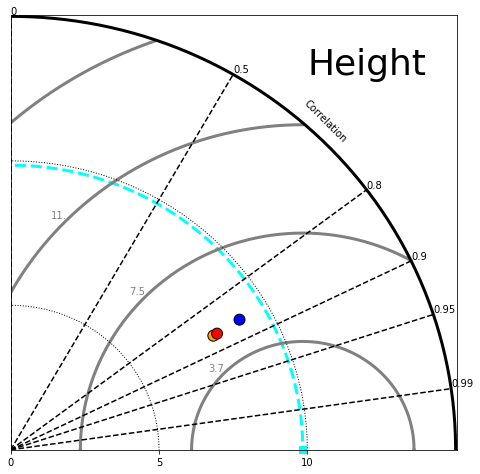

In [325]:
# Test out the makeTaylor diagram function. Will have to adject the circ_LIM for the standard deviation values.

## Note: I did play around a bit with the makeTaylor function to get it to plot correctly. 
## Depending on the data you may need to adjust the figure size, 

makeTaylor(corrs,stds,stdobs,circ_LIM=15.0,loc='Height')